# Interpolación en dominios bi-dimensionales

## Introducción

Acá extenderemos el esquema de interpolación uni-dimensional estudiado previamente al caso mas general de un dominio bi-dimensional. Desde el punto de vista geométrico también veremos como un **elemento finito** es solo un dominio espacial canonico descrito por puntos nodales y el correspondiente grupo de funciones de interpolación (o de **forma**). **Al completar este notebook usted debería estar en la capacidad de:**

* Reconocer el problema de interpolación en dominios bi-dimensionales como uno de aplicación de los esquemas uni-dimensionales.

* Formalizar el concepto de un elemento finito como un espacio de interpolación canonico con funciones de interpolación predefinidas.

* Proponer esquemas de interpolación para dominios bi-dimensionales arbitrarios.

## Dominio bi-dimensional
Consideremos el dominio cuadrado mostrado en la figura y en el cual queremos aproximar, por medio de interpolación, una función escalar (o vectorial) $f=f(x,y)$. Para ese proposito los puntos negros en la figura representan puntos nodales donde asumimos que la función es conocida. En este caso el polinomio de interpolación, denotado por $p(x,y)$ se construye como:

$$p(x,y) = H^Q(x,y)f^Q$$

donde $Q = 1,...,N$ para un dominio de *N* puntos nodales y donde $H^Q(x,y)$ son las funciones de interpolación o funciones de forma. **La expresión con superindices $Q$ implica que hay una sumatoria desde $Q=1$ hasta $N$.** 


Como se detallará a continuación para construir las funciones de interpolación bi-dimensionales $ H^Q(x,y)$  en realidad aplicamos un proceso de interpolaciones uni-dimensionales iteradas.

Denotemos como $x^A$ y $x^B$ a las coordenadas de los puntos A y B en el dominio cudrado mostrado en la figura y supongamos que queremos encontrar el valor de la función en el punto A.

<center><img src="images/element.png" alt="Element" style="width:300px"></center>

El punto A tiene una coordenada en $y$ que es arbitraria pero una coordenada en $x$ constante correspondiente a $x = x^A$ de manera que para un punto A arbitrario a lo largo de la dirección 1-4 (ver figura) el esquema de interpolación es aún uni-dimensional solamente con dependencia en $y$ y expresado como $f(y , x= A)$ en la figura. Usando polinomios de interpolación de Lagrange uni-dimensionales la dependencia en $y$ puede ser capturada por:

$$f(x^A , y) = L^1(y)f^1 + L^4(y)f^4$$


<center><img src="images/inter1D.png" alt="1direction" style="width:300px"></center>

Procediendo de manera similar para un punto arbitrario $B$ a lo largo de la dirección 2-3 se tiene que:

$$f(x^B , y) = L^2(y)f^2 + L^3(y)f^3.$$

con $f^A$ y $f^B$ conocidos la dependencia en $x$ puede capturarse como:

$$f(x,y) = L^A(x) f(x^A,y) + L^B(x)f(x^B,y).$$

Para llegar a la forma final de las funciones de forma bi-dimensionales calculamos los polinomios $L^2(y)$, $L^3(y)$, $ L^A(x)$ y $ L^B(x)$ y los reemplazamos en las expresiones anteriores. En el caso de un elemento de lado $2.0$ las funciones son:

\begin{align*}
H^1(x,y) & = L^1(x)L^1(y) \equiv \frac14(1-x)(1-y)\\
H^2(x,y) & = L^2(x)L^1(y) \equiv \frac14(1+x)(1-y)\\
H^3(x,y) & = L^2(x)L^2(y) \equiv \frac14(1+x)(1+y)\\
H^4(x,y) & = L^1(x)L^2(y) \equiv \frac14(1-x)(1+y).
\end{align*}

### Elemento finito canonico
En la siguiente subrutina codificamos la forma final $H^Q(x,y)$ de las funciones de forma en vez de calcular directamente los polinomios fundamentales en una dimensión de la forma $L^I(y)$ para posteriormente realizar la interpolación iterada. La subrutina llamada **sha4()** almacena las funciones en una estructura matricial que depende de $x$ y $y$. Acá asumimos que el elmento es un cuadrdado perfecto de lado $\mathcal l=2.0$ con puntos nodales en las esquinas correspondiente a una interpolación líneal a lo largo de cada cara.

In [1]:
%matplotlib notebook        
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from scipy import interpolate

In [2]:
def sha4(x,y):
    """
    Compute the shape functions for bi-linear
    square element of size 2.0.
    """
    sh=sym.zeros(4)
    sh[0] =(1.0/4.0)*(1 - x)*(1 - y)
    sh[1] =(1.0/4.0)*(1 + x)*(1 - y)
    sh[2] =(1.0/4.0)*(1 + x)*(1 + y)
    sh[3] =(1.0/4.0)*(1 - x)*(1 + y)
#
    return sh

Este elemento cuadrado es un elemento **canonico** o de referencia en el cual es fácil la realización de las operaciones de interpolación. En una malla real de elementos finitos es de esperar que los elementos esten distorsionados en relación con este elemento canonico. En esos casos la interpolación también se realiza en el espacio del elemento canonico pero ahora tanto la geometría como las funciones son transformadas usando operaciones matemáticas. Estos detalles sin embargo no se discutirán acá.

Las funciones de forma almacenadas en la subrutina corresponden a:

$$H = \frac14\begin{bmatrix}(1-x)(1-y)&(1+x)(1-y)&(1+x)(1+y)&(1-x)(1+y)\end{bmatrix}$$

**Preguntas:**

**(i) Escriba las funciones de forma asumiendo que el sub-dominio el mismo cuadrado discutido hasta el momento, pero además de los nudos de la esquina también incluye nudos en la mitad de las caras para completar un total de 8 puntos nodales.**

**(ii) Haga una copia de la subrutina **sha4()** **y modifiquela para que calcule las funciones de forma para el elemento de 8 nudos.**

In [3]:
x , y= sym.symbols('x y')
H = sha4(x , y)

## Interpolación en un dominio cudrado

En este paso consideramos un elemento cudrado conformado por 4 puntos nodales localizados en las esquinas y donde se asumen conocidos los valores de la función. Usaremos estos valores, conjuntamente con las funciones de forma para encontrar un polinomio de interpolación. El polinomio resultante se usa posteriormente para generar valores aproximados de la función en una serie de puntos que conforman una grilla usada para visualizar la solución. La grilla de puntos de observación se genera usando la función **mgrid** de **numpy**.

Note que el sistema de referencia se localiza en el centro del elemento por lo tanto $x\in\lbrack-1\;,\;1\rbrack$ and $y\in\lbrack-1\;,\;1\rbrack$. El arreglo uni-dimensional **USOL[]** almacenará los valores interpolados en cada punto de la grilla.

Para realizar la interpolación asumiremos valores nodales de la función en un punto dado $(x , y)$  de manera que podemos obtener el valor interpolado como:

$$u(x,y)\;=\;\left[H(x,y)\right]\left\{u\right\}$$

**(Agregue comentarios para aclarar los pasos mas relevantes del siguiente código)**.

<IPython.core.display.Javascript object>


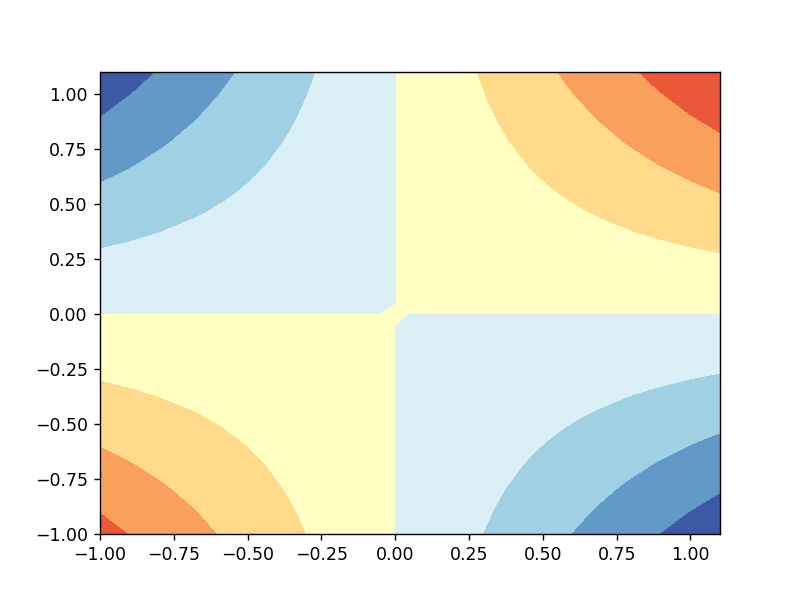

In [4]:
li=-1.0
ls= 1.1
dl= 0.1
npts=int((ls-li)/dl)
USOL = np.zeros((npts, npts, 1))
xx, yy = np.mgrid[li:ls:npts*1j, li:ls:npts*1j]
#Try different values of the function at the nodal points
u = sym.Matrix(4, 1, [-0.2 ,0.2 ,-0.2 , 0.2])
#
for i in range(npts):
    for j in range(npts):
        NS =H.subs([(x, xx[i,j]), (y, yy[i,j])])
        up  = NS*u
        USOL[i, j, 0] = up[0]
plt.figure(1)
plt.contourf(xx , yy , USOL[:,:,0], cmap="RdYlBu")

### Glosario de términos

**Elemento finito canonico:** Sub-dominio no distorsionado de tamaño constante y con funciones de forma únicas. En un caso práctico lo elementos difieren en tamaño y nivel de distorión, sin embargo todos ellos son transformados al elemento canonico.

**Funciones de forma:** Funciones de interpolación formuladas sobre un elemento canonico.

**Malla:** Conjunto de elementos finitos que cubren un dominio computacional dado. Se dice que una malla ha sido refinada cuando el tamaño caracteristico de sus elementos se reduce produciendo un mayor numero de elementos para cubrir el mismo dominio computacional.

### Actividad para la clase

Extender el esquema de interpolación en 2D discutido previamente al caso de una función vectorial en el contexto de teoría de la elasticidad con las siguientes consideraciones:

* Asuma que el vector de desplazamientos con componentes horizontal y vertical $u$ y $v$ respectivamente es conocido en cada nudo del dominio cuadrado.

* Usando los valores nodales del vector de desplazamientos calcule las componentes horizontal  y vertical a lo largo del elemento (al interior).

* Usando los valores nodales calculo el campo de deformaciones unitarias definido por:

$$\varepsilon_{xx}=\frac12\left(\frac{\partial u}{\partial x}\right)$$

$$\varepsilon_{yy}=\frac12\left(\frac{\partial v}{\partial y}\right)$$

$$\gamma_{yy}=\left(\frac{\partial u}{\partial y}+\frac{\partial v}{\partial x}\right)$$

* Almacene las derivadas de las funciones de forma en una matriz independiente $B$.

In [5]:
# This bit of code is a class added to make the title nice  (thanks to @lorenABarba )
from IPython.core.display import HTML
def css_styling():
    styles = open('./styles/custom_barba.css', 'r').read()
    return HTML(styles)
css_styling()

(c) Juan Gomez, Nicolas Guarín 2019. Este material es parte del curso Modelación Computacional en el programa de Ingeiería Civil de la Universidad EAFIT.